# History of big data frameworks

In Q3 of 1997, there were 4 teams working independently. Randy Shoup's team at eBay, Greg Linden's team at Amazon, Eric Brewer's team at Inktomi at Berkeley which later became Yahoo Search and Larry and Sergey at Stanford ready to spin out next year's Google. All 4 teams were working on this idea of *horizontal scale-out*.

Back in the 90's if you wanted to scale your web app you had to buy bigger and bigger servers. Probably a Sun server with a Oracle license. eBay had 4 servers and Amazon had similar big Sun servers. But they realized in Q3 1997 that if the e-commerce thing really grew they were gonna be in trouble because they wouldn't be able to handle the load and Sun and IBM and Oracle and others would be taking the money out on the table.

Randy Shoup's team and Greg Linden's team have published retrospectives of what they were thinking at that time. They took their workloads and parallelized them and rewrote them such that they could run on commodity hardware. They did that in Q3 97 and in Q4 97 the tsunami of e-commerce hit. So holiday season of 97, eBay and Amazon were able to scale out horizontally and absorb all the web traffic and become mega-billion dollar companies.

By able to horizontally scale-out on commodity hardware meant they could store the log files from the web apps. At the middleware layer, we were collecting a lot of logs as to how people are interacting with the web apps. What Yahoo, Google and others did was to take those log files or machine data, aggregate them and feed the aggregated log files to machine learning and create classifiers, recommender systems and other *data products*. These products were then fed back into the web apps to enable richer interaction. So we get this virtuous cycle of improvement. Back in those days, most of the data on the web apps were entered by people. Most of this data was overshadowed by machine-generated data. More and more machine data led to the need for larger and larger clusters.

Around 2002, Google had been doing horizontal scale-out and they had a fairly complex machine learning workloads to compute PageRank, crawl websites etc. If you are doing roll-up of log files for reporting, doing that in a distributed fashion on a cluster is a no-brainer. But when you are doing complex workloads, you run into the failures interrupting your job to the point where you can't complete it. 

If you are doing some machine learning workloads on a 2000-node cluster, the expected number of failures per day (current day) is about 10 nodes. This is mainly because of spinning disks. Back in 2002, the probability of finishing a job with need to restart the job if a node fails was almost 0. So the first thing Google did was to build out a distributed file system (**GFS**) to get through some of the problems with spinning disks. On top of that they built **MapReduce**. It wasn't so much about *speed*, it was about *fault tolerance*.  

In 2004, *Sanjay Ghemavat* and *Jeff Dean* published the [MapReduce paper](http://static.googleusercontent.com/media/research.google.com/en/us/archive/mapreduce-osdi04.pdf). In the first paragraph they mentioned how they borrowed concepts from functional programming to build fault tolerance. In particular, the math for this goes back to the 1930s when Alonso Church and Haskell Curry were working on the concepts of *combinators* and *lambda calculus*. They came up with patterns to define what could be computed even years before they had digital computers to work with. But lambda calculus itself has some different patterns. One is called map and other is called reduce and several others. So to create MapReduce they had gone back to the math of the 1930s and it's what Spark is based on.

Since 2002, the disks have changed, memory is cheaper, networks are much faster (gigabit), SDN (Software-defined networking) exists. So the commodity hardware has leveled up. 

MapReduce did get us out with some of the problems with horizontal scale-out but it had introduced some other problems:

* Programming in terms of map and reduce abstractions for complex applications is hard and very few developers can think in terms of coding in those abtractions. Since late 2007, we've had implementations to make this easier like Cascading, Pig, Hive etc.
* Working with a MapReduce framework, you have different types of performance issues. One of the big ones is *key-value skew*. For example if you are Twitter, the average number of followers for a person is around 200. But big stars like Lady Gaga and Katy Perry have millions of followers. When doing operations on these people who act as keys in the MapReduce programs, a single reducer getting this key takes a significant time to complete compared to other (normal) people. This affects the efficiency of cluster utilization.

The trend is generally that Google publishes a paper and then others pick it up and implement open-source versions of it. MapReduce was picked up as the Nutch project which was sponsored by Yahoo and became Hadoop in 2006.

Since MapReduce doesn't compose well for large applications, specialized systems have evolved around it like *Pregel*, *Giraph*, *GrpahLab*, *Dremel*, *F1*, *Impala*, *MillWheel*, *Storm* etc to deal with specific applications like streaming, graph processing etc. The downside of using specialized systems is that it requires more cluster compute resources. Second issue is to get the Ops team to manage these systems at scale which is very expensive. Google, Yahoo or Twitter have armies of specialized Ops people but hiring that kind of talent for other companies or startups is very difficult. Third issue is training people to manage all these systems. Fourth issue is managing the flow of data from one system to another which incurs a loss in latency which is critical for businesses like Finance and advertising.

So around 2009, people started thinking that all these systems are great but what we need is something *general* working on one cluster which can handle all these types of use cases.

### Origin of Spark

At that time, Matei Zaharia was an intern at Cloudera and working with Hadoop on such use cases. Ben Hindman was working at that time at Google developing cluster management resources which got cancelled. He went to Berkeley to join RADLab where people were working on what is now called **Mesos** which is to run different workloads on commodity hardware. 

In Spring of 2009, Ben and his colleagues came up with a first dedicated Mesos framework looking to build something faster than Hadoop. Matei was working on Scala on top of Mesos and came up with an alternative on MapReduce which is now **Spark**. That was the origin of Spark. It was developed in AMPLab at Berkeley in 2009 and open sourced in 2010. 

### Spark objectives

Unlike the various specialized systems, Spark's goal was to *generalize* MapReduce to support new apps within same engine.

Two reasonably small additions are enough to express the previous models:

* fast data sharing (memory caching)
* general DAGs

The second concept came out of the **DryadLINQ** project at Microsoft Research.  

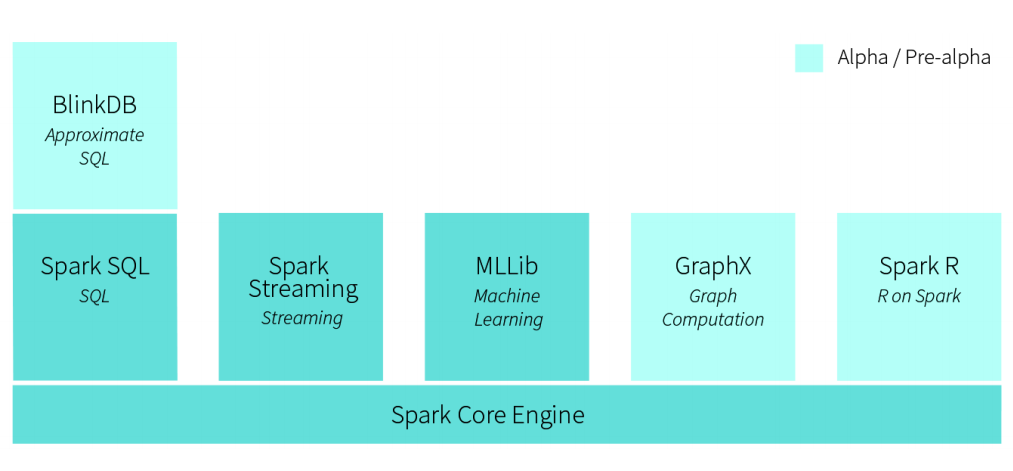

In [1]:
from IPython.display import Image
Image(filename='Spark_ecosystem.png')

In MapReduce, to deal with spinning disk failures they created **synchronisation barriers**. There are 3 synchronisation barriers per job in MapReduce. Now when doing complex ML jobs in 2008, the pipleine would be something like 15 MR jobs which looked like Map-Map-Map-Filter-Reduce having a lot of barriers to deal with. Now we don't care so much about disk failures and we have handled that mostly with something like Cassandra. So now we can relax some constraints of such barriers and treat the long operations as one function composition operation borrowing again from lambda calculus. So using abstract algebra and lazy evaluation we can come up with a much more efficient pipeline. 

**Repartitioning** is important in Spark. After we have loaded the data and done some operations like transforms, joins or ML iterations, the data is unevenly distributed on the cluster. Repartitioning the data in such a phase can prove helpful for optimizing. Key is to reduce shuffle as much as possible.

As an example while doing a join, if we can place the keys from the left and right table that need to be joined in the same place, we eliminate much of the network traffic.

There is a generational aspect to cluster computing. If you were back in the early 2000s, suddenly disk became cheap. If you have really cheap storage, you want to distribute your data. There is a notion of *replication*. Going back in the 90s, networking became cheaper. So if you wanted to do a distributed problem, you could just do a URL call. So there is a generational change between reference and replication. Getting into the 2010s, we have other types of resources getting cheaper like multicore and memory and there the tradeoff is if you can *recompute*. If I have some simple operations in my graph, I will just recompute instead of making a reference call. It is possible that maybe 5 years down the line there is a breakthrough in networking and compute by reference becomes cheap again.

Spark has no concept of storage. So it has to be married with some kind of file system like HDFS. When we move to real-time use cases Hadoop becomes a bottleneck.

Since you have multicore, it makes sense to use containers using CGroups. Spark came out of Mesos. The notion in Mesos was if you have a machine with 24 cores and 128 Gb of RAM, you can parcel those resources into containers which would look like independent nodes. But it's a way of getting rid of virtualization. 

Google doesn't use virtualization. They use something similar to Mesos called Borg (now Omega). They do Dev, QA and Production all on the same machines. By virtue of having containers they can isolate these environments. That's the good thing about Spark that you have a new hardware and containers are a game-changer.